In [2]:
import tensorflow as tf

In [3]:
for gpu in tf.config.experimental.list_physical_devices("GPU"):
    tf.compat.v2.config.experimental.set_memory_growth(gpu, True)

In [4]:
import logging
logging.getLogger("tensorflow").disabled = True

In [5]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop

In [6]:
conv_base = VGG16(weights="imagenet",
                  include_top=False,
                  input_shape=(150,150,3))

In [7]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [8]:
train_dir = "/home/rtx/jobin/chollet_keras/data/kaggle_pets/train/"
valid_dir = "/home/rtx/jobin/chollet_keras/data/kaggle_pets/val/"
test_dir = "/home/rtx/jobin/chollet_keras/data/kaggle_pets/test/"

In [9]:
batch_size = 50
gen = ImageDataGenerator(rescale=1./255)

def extract_features(directory, sample_count):
    features = np.zeros((sample_count,4,4,512))
    labels = np.zeros((sample_count))
    generator = gen.flow_from_directory(directory,
                                        target_size=(150,150),
                                        batch_size=batch_size,
                                        class_mode="binary")
    i = 0
    for inputs_batch, labels_batch in generator:
        features[i*batch_size : (i+1)*batch_size] = conv_base.predict(inputs_batch)
        labels[i*batch_size : (i+1)*batch_size] = labels_batch
        i += 1
        if i*batch_size >= sample_count:
            break
    return features,labels

In [10]:
train_features, train_labels = extract_features(train_dir, 17500)
val_features, val_labels = extract_features(valid_dir, 2500)
test_features, test_labels = extract_features(test_dir, 5000)

Found 17500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [21]:
train_features = train_features.reshape(17500, 4*4*512)
val_features = val_features.reshape(2500, 4*4*512)
test_features = test_features.reshape(5000, 4*4*512)

In [31]:
model = Sequential([
    Dense(256,activation="relu",input_shape=(4*4*512,)),
    Dropout(0.5),
    Dense(1,activation="sigmoid")
])

In [32]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(optimizer=RMSprop(lr=2e-05),
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [34]:
history = model.fit(train_features,train_labels,
                    epochs=30,
                    batch_size=50,
                    validation_data=(val_features,val_labels))

Train on 17500 samples, validate on 2500 samples
Epoch 1/30
17500/17500 [==============================] - 1s 72us/sample - loss: 0.4128 - accuracy: 0.8031 - val_loss: 0.2707 - val_accuracy: 0.8964
Epoch 2/30
17500/17500 [==============================] - 1s 57us/sample - loss: 0.2880 - accuracy: 0.8759 - val_loss: 0.2373 - val_accuracy: 0.9016
Epoch 3/30
17500/17500 [==============================] - 1s 57us/sample - loss: 0.2530 - accuracy: 0.8933 - val_loss: 0.2212 - val_accuracy: 0.9124
Epoch 4/30
17500/17500 [==============================] - 1s 57us/sample - loss: 0.2348 - accuracy: 0.9032 - val_loss: 0.2118 - val_accuracy: 0.9116
Epoch 5/30
17500/17500 [==============================] - 1s 58us/sample - loss: 0.2255 - accuracy: 0.9072 - val_loss: 0.2020 - val_accuracy: 0.9188
Epoch 6/30
17500/17500 [==============================] - 1s 58us/sample - loss: 0.2100 - accuracy: 0.9145 - val_loss: 0.2030 - val_accuracy: 0.9208
Epoch 7/30
17500/17500 [==============================] -

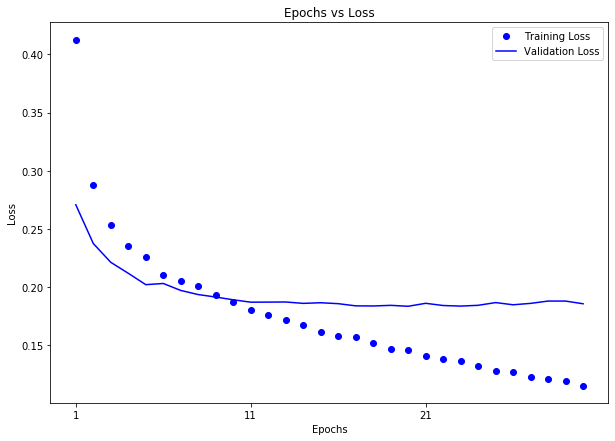

In [35]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1,len(history.history["accuracy"])+1)

plt.figure(figsize=(10,7))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epochs vs Loss")
plt.xticks(np.arange(min(epochs),max(epochs)+1,10))
plt.plot(epochs,loss,"bo",label="Training Loss")
plt.plot(epochs,val_loss,"b",label="Validation Loss")
plt.legend()

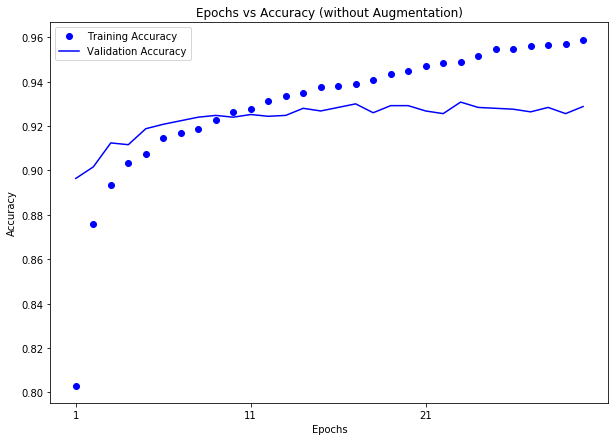

In [36]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1,len(history.history["accuracy"])+1)

plt.figure(figsize=(10,7))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Epochs vs Accuracy (without Augmentation)")
plt.xticks(np.arange(min(epochs),max(epochs)+1,10))
plt.plot(epochs,acc,"bo",label="Training Accuracy")
plt.plot(epochs,val_acc,"b",label="Validation Accuracy")
plt.legend()

In [46]:
model = Sequential([
    conv_base,
    Flatten(),
    Dense(256,activation="relu"),
    Dropout(0.5),
    Dense(1,activation="sigmoid")
])

In [47]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [48]:
len(model.trainable_weights)

4

In [49]:
conv_base.trainable = False

In [50]:
len(model.trainable_weights)

4

In [51]:
model.compile(optimizer=RMSprop(lr=2e-05),
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [52]:
traingen = ImageDataGenerator(rescale=1./255,
                             rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode="nearest")

testgen = ImageDataGenerator(rescale=1./255)

In [53]:
train_generator = traingen.flow_from_directory(train_dir,
                                               target_size=(150,150),
                                               batch_size=50,
                                               class_mode="binary")
validation_generator = testgen.flow_from_directory(valid_dir,
                                                   target_size=(150,150),
                                                   batch_size=50,
                                                   class_mode="binary")

Found 17500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [54]:
history = model.fit_generator(train_generator,
                    epochs=30,
                    steps_per_epoch=584,
                    validation_data=validation_generator,
                    workers=16,
                    max_queue_size=128)

Epoch 1/30
584/584 [==============================] - 52s 89ms/step - loss: 0.5107 - accuracy: 0.7449 - val_loss: 0.2916 - val_accuracy: 0.8840
Epoch 2/30
584/584 [==============================] - 50s 86ms/step - loss: 0.3872 - accuracy: 0.8252 - val_loss: 0.2500 - val_accuracy: 0.9020
Epoch 3/30
584/584 [==============================] - 49s 84ms/step - loss: 0.3618 - accuracy: 0.8376 - val_loss: 0.2331 - val_accuracy: 0.9060
Epoch 4/30
584/584 [==============================] - 48s 82ms/step - loss: 0.3431 - accuracy: 0.8468 - val_loss: 0.2315 - val_accuracy: 0.9100
Epoch 5/30
584/584 [==============================] - 50s 85ms/step - loss: 0.3274 - accuracy: 0.8543 - val_loss: 0.2179 - val_accuracy: 0.9144
Epoch 6/30
584/584 [==============================] - 50s 85ms/step - loss: 0.3260 - accuracy: 0.8537 - val_loss: 0.2180 - val_accuracy: 0.9180
Epoch 7/30
584/584 [==============================] - 48s 83ms/step - loss: 0.3212 - accuracy: 0.8577 - val_loss: 0.2197 - val_accuracy:

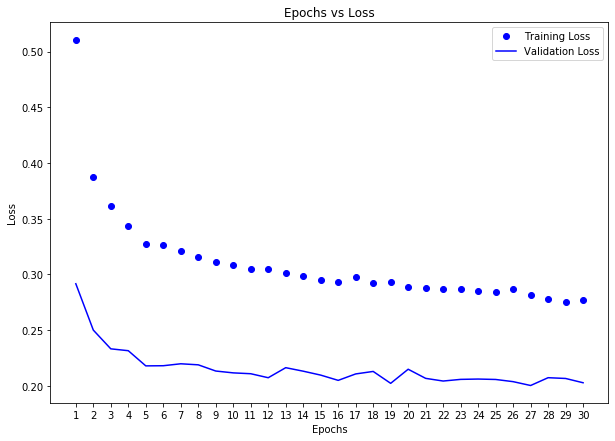

In [57]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1,len(history.history["accuracy"])+1)

plt.figure(figsize=(10,7))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epochs vs Loss")
plt.xticks(np.arange(min(epochs),max(epochs)+1,1))
plt.plot(epochs,loss,"bo",label="Training Loss")
plt.plot(epochs,val_loss,"b",label="Validation Loss")
plt.legend()

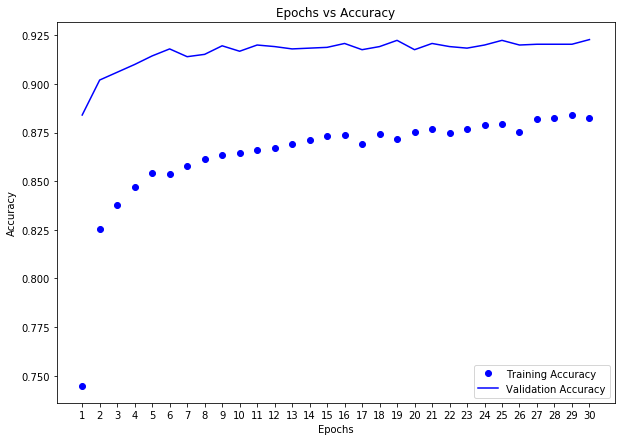

In [58]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1,len(history.history["accuracy"])+1)

plt.figure(figsize=(10,7))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Epochs vs Accuracy")
plt.xticks(np.arange(min(epochs),max(epochs)+1,1))
plt.plot(epochs,acc,"bo",label="Training Accuracy")
plt.plot(epochs,val_acc,"b",label="Validation Accuracy")
plt.legend()